### setup

In [2]:
!pip install Levenshtein
!pip install einops
!pip install einops_exts
!pip install torch
!pip install transformers
!pip install tqdm
!pip install sentencepiece
# !pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import re
import math
import json
from tqdm import tqdm
from einops import rearrange, repeat
# import esm

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# # Load ESM-2 model
# esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# batch_converter = alphabet.get_batch_converter()
# esm_model = esm_model.to(device)  # Move to GPU if available
# esm_model.eval()  # Set to evaluation mode


Using device: cuda


### data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def preprocess_snp_data(file_path):
    snp_df = pd.read_csv(file_path)

    # Basic preprocessing and length calculations
    snp_df['smiles_length'] = snp_df['smiles'].apply(len)
    snp_df['protein_length'] = snp_df['protein_sequence'].apply(len)

    return snp_df

def filter_datasets(dataset):
    return dataset[
        (dataset['smiles'].notna()) &
        (dataset['protein_sequence'].notna()) &
        (dataset['smiles_length'] > 0) &
        (dataset['protein_length'] > 0)
    ]

class ProteinGenerationDataset(Dataset):
    def __init__(self, dataframe, max_length):
        self.dataframe = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return row['smiles'], row['protein_sequence']

def collate_fn(batch):
    """
    Custom collate function to handle padding within batches.
    Args:
        batch: List of tuples (smiles, protein)
    Returns:
        Padded and batched tensors
    """
    smiles, proteins = zip(*batch)

    # SMILES strings don't need padding as PolyBERT handles that internally
    smiles = list(smiles)

    # Get max length in this batch for proteins (not exceeding dataset max_length)
    max_protein_len = min(max(len(p) for p in proteins), max_length)

    # Pad proteins to max length in batch
    padded_proteins = []
    protein_masks = []

    for protein in proteins:
        if len(protein) > max_protein_len:
            padded = protein[:max_protein_len]
            mask = [1] * max_protein_len
        else:
            padded = protein + ' ' * (max_protein_len - len(protein))
            mask = [1] * len(protein) + [0] * (max_protein_len - len(protein))

        padded_proteins.append(padded)
        protein_masks.append(mask)

    return {
        'smiles': smiles,
        'proteins': padded_proteins,
        'protein_masks': torch.tensor(protein_masks, dtype=torch.bool)
    }

### utils

In [6]:
# Model Components
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class PerceiverAttention(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm_media = nn.LayerNorm(dim)
        self.norm_latents = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x, latents):
        """
        x: [batch_size, seq_len_x, dim]
        latents: [batch_size, seq_len_l, dim]
        """
        batch_size = x.shape[0]

        x = self.norm_media(x)
        latents = self.norm_latents(latents)

        # Ensure latents has correct batch size
        if latents.size(0) != batch_size:
            latents = latents.expand(batch_size, -1, -1)

        q = self.to_q(latents)
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        q = q * self.scale

        # Ensure proper concatenation
        kv_input = torch.cat((x, latents), dim=1)  # concatenate along sequence dimension
        k, v = self.to_kv(kv_input).chunk(2, dim=-1)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        sim = torch.einsum('b h i d, b h j d -> b h i j', q, k)
        attn = sim.softmax(dim=-1)
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class GatedCrossAttentionBlock(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, ff_mult=4):
        super().__init__()
        self.attn = PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads)
        self.attn_gate = nn.Parameter(torch.tensor([0.]))
        self.ff = FeedForward(dim, mult=ff_mult)
        self.ff_gate = nn.Parameter(torch.tensor([0.]))

    def forward(self, x, media):
        """
        x: [batch_size, seq_len_x, dim]
        media: [batch_size, seq_len_m, dim]
        """
        batch_size = x.shape[0]
        target_batch_size = media.size(0)

        # Handle batch size mismatch
        if batch_size > target_batch_size:
            media = media.expand(batch_size, -1, -1)
        elif batch_size < target_batch_size:
            x = x.expand(target_batch_size, -1, -1)

        gate = self.attn_gate.tanh()
        x = self.attn(media, x) * gate + x
        x = self.ff(x) * self.ff_gate.tanh() + x
        return x

class PerceiverResampler(nn.Module):
    def __init__(self, dim, depth, dim_head=64, heads=8, num_latents=64):
        super().__init__()
        # Initialize latents without batch dimension
        self.latents = nn.Parameter(torch.randn(num_latents, dim))
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
                FeedForward(dim=dim)
            ]))

    def forward(self, x):
        batch_size = x.shape[0]
        # Expand latents to batch size
        latents = repeat(self.latents, 'n d -> b n d', b=batch_size)

        for attn, ff in self.layers:
            latents = attn(x, latents) + latents
            latents = ff(latents) + latents

        return latents

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * mult, bias=False),
            nn.GELU(),
            nn.Linear(dim * mult, dim, bias=False)
        )

    def forward(self, x):
        return self.net(x)

# class PerceiverResampler(nn.Module):
#     def __init__(self, dim, depth, dim_head=64, heads=8, num_latents=64):
#         super().__init__()
#         self.latents = nn.Parameter(torch.randn(num_latents, dim))
#         self.layers = nn.ModuleList([])

#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads),
#                 FeedForward(dim=dim)
#             ]))

#     def forward(self, x):
#         latents = repeat(self.latents, 'n d -> b n d', b=x.shape[0])

#         for attn, ff in self.layers:
#             latents = attn(x, latents) + latents
#             latents = ff(latents) + latents

#         return latents

# class GatedCrossAttentionBlock(nn.Module):
#     def __init__(self, dim, dim_head=64, heads=8, ff_mult=4):
#         super().__init__()
#         self.attn = PerceiverAttention(dim=dim, dim_head=dim_head, heads=heads)
#         self.attn_gate = nn.Parameter(torch.tensor([0.]))
#         self.ff = FeedForward(dim, mult=ff_mult)
#         self.ff_gate = nn.Parameter(torch.tensor([0.]))

#     def forward(self, x, media):
#         gate = self.attn_gate.tanh()
#         x = self.attn(media, x) * gate + x
#         x = self.ff(x) * self.ff_gate.tanh() + x
#         return x

### PolyBert Encoder

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch


In [8]:
# class PolyBERTEncoder(nn.Module):
#     def __init__(self, output_dim):
#         super().__init__()
#         self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
#         self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
#         self.output_dim = output_dim
#         # Add a projection layer to match the required dimension
#         self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

#     def mean_pooling(self, model_output, attention_mask):
#         token_embeddings = model_output[0]
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#         return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

#     def forward(self, smiles_strings):
#         # Tokenize the SMILES strings
#         encoded_input = self.tokenizer(smiles_strings,
#                                      padding=True,
#                                      truncation=True,
#                                      return_tensors='pt').to(next(self.polybert.parameters()).device)

#         # Get PolyBERT embeddings
#         with torch.no_grad():
#             model_output = self.polybert(**encoded_input)

#         # Debug prints
#         print("Model Output Keys:", model_output.keys())  # Check available keys
#         # print("Last Hidden State:", model_output.last_hidden_state)
#         print("Last Hidden State Shape:", model_output.last_hidden_state.shape)

#         # Pool the embeddings
#         pooled_output = self.mean_pooling(model_output, encoded_input['attention_mask'])

#         # print("Pooled Output:", pooled_output)
#         print("Pooled Output Shape:", pooled_output.shape)

#         # Project to required dimension
#         projected_output = self.projection(pooled_output)

#         return projected_output

In [9]:
class PolyBERTEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.polybert = AutoModel.from_pretrained('kuelumbus/polyBERT')
        self.tokenizer = AutoTokenizer.from_pretrained('kuelumbus/polyBERT')
        self.output_dim = output_dim
        # Project each token embedding to required dimension
        self.projection = nn.Linear(self.polybert.config.hidden_size, output_dim)

    def forward(self, smiles_strings):
        # Tokenize the SMILES strings
        encoded_input = self.tokenizer(smiles_strings,
                                     padding=True,
                                     truncation=True,
                                     return_tensors='pt').to(next(self.polybert.parameters()).device)

        # Get PolyBERT embeddings
        with torch.no_grad():
            model_output = self.polybert(**encoded_input)

        # Debug prints
        # print("Model Output Keys:", model_output.keys())
        # print("Last Hidden State Shape:", model_output.last_hidden_state.shape)  # [batch_size, seq_len, hidden_size]

        # Get sequence embeddings
        sequence_embeddings = model_output.last_hidden_state

        # Project each token embedding to required dimension
        projected_output = self.projection(sequence_embeddings)  # [batch_size, seq_len, output_dim]
        # print("Projected Output Shape:", projected_output.shape)

        return projected_output

### ProtFlamingo

In [10]:
class ProtFlamingo(nn.Module):
    def __init__(self, model_path, max_len, cross_attn_every=1, dim_head=64, heads=8, perceiver_depth=2, perceiver_num_latents=64):
        super().__init__()

        self.protGPT2_model = GPT2LMHeadModel.from_pretrained(model_path)
        self.protGPT2_tokenizer = GPT2Tokenizer.from_pretrained(model_path)
        self.max_len = max_len

        if self.protGPT2_tokenizer.pad_token is None:
            self.protGPT2_tokenizer.pad_token = self.protGPT2_tokenizer.eos_token
            self.protGPT2_model.config.pad_token_id = self.protGPT2_model.config.eos_token_id

        self.cross_attn_every = cross_attn_every

        # PolyBERT encoder for SMILES strings
        self.polybert_encoder = PolyBERTEncoder(self.protGPT2_model.config.n_embd)
        self.positional_encoding = PositionalEncoding(self.protGPT2_model.config.n_embd, max_len=max_len)

        # Single perceiver resampler for SMILES embeddings
        self.smiles_perceiver = PerceiverResampler(
            dim=self.protGPT2_model.config.n_embd,
            depth=perceiver_depth,
            dim_head=dim_head,
            heads=heads,
            num_latents=perceiver_num_latents
        )

        # Cross attention layers
        num_gpt_layers = len(self.protGPT2_model.transformer.h)
        self.cross_attn = nn.ModuleList([
            GatedCrossAttentionBlock(dim=self.protGPT2_model.config.n_embd, dim_head=dim_head, heads=heads)
            for _ in range(num_gpt_layers)
        ])

        # Combine GPT layers with cross attention
        self.layers = nn.ModuleList()
        for i, block in enumerate(self.protGPT2_model.transformer.h):
            self.layers.append(block)
            if i % cross_attn_every == 0 and i != 0:
                self.layers.append(GatedCrossAttentionBlock(dim=self.protGPT2_model.config.n_embd, dim_head=dim_head, heads=heads))

    def forward(self, smiles_strings):
      device = next(self.parameters()).device

      # Get SMILES embeddings through PolyBERT
      # print("Getting SMILES embeddings...")
      smiles_embeddings = self.polybert_encoder(smiles_strings)  # [batch_size, seq_len, hidden_dim]
      processed_smiles = self.smiles_perceiver(smiles_embeddings)
      # print("processed smiles thru encoder and perceiver...")

      # Initialize with start token
      # print("gpt initialized...")
      gpt_input = self.protGPT2_tokenizer.encode_plus(
          "<|endoftext|>",
          return_tensors="pt",
          padding='max_length',
          max_length=self.max_len,
          truncation=True
      ).to(device)

      # print("input ids and hidden states defined (gpt + positional)...")
      input_ids = gpt_input.input_ids.long()
      hidden_states = self.protGPT2_model.transformer.wte(input_ids)
      hidden_states = self.positional_encoding(hidden_states)

      # Create proper attention mask
      attention_mask = gpt_input.attention_mask
      # Extend attention mask for batch size and heads
      batch_size = hidden_states.shape[0]
      num_heads = self.protGPT2_model.config.n_head
      seq_length = hidden_states.shape[1]

      # Create 4D attention mask [batch_size, num_heads, seq_length, seq_length]
      attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
      attention_mask = attention_mask.expand(batch_size, num_heads, seq_length, seq_length)
      attention_mask = attention_mask.to(dtype=hidden_states.dtype)  # Convert to same dtype as hidden states

      # print("start to pass thru layers with cross attn")
      for i, layer in enumerate(self.layers):
          if isinstance(layer, GatedCrossAttentionBlock):
              # print('LAYER DEFINE _______ gated layer')
              hidden_states = layer(hidden_states, processed_smiles)
          else:
              # print('LAYER DEFINE _______ no gated layer')
              hidden_states = layer(hidden_states, attention_mask=attention_mask)[0]

      # print('done... returning lm head of hidden states (Decoded)')
      return self.protGPT2_model.lm_head(hidden_states)

    def custom_generate(self, smiles_string, max_length=200):
        device = next(self.parameters()).device

        # Get SMILES embeddings
        smiles_embeddings = self.polybert_encoder(smiles_string)
        processed_smiles = self.smiles_perceiver(smiles_embeddings)

        # Initialize with start token
        input_ids = torch.tensor([[self.protGPT2_tokenizer.bos_token_id]]).to(device)

        # Autoregressive generation
        for _ in range(max_length):
            inputs_embeds = self.protGPT2_model.transformer.wte(input_ids)
            inputs_embeds = self.positional_encoding(inputs_embeds)

            hidden_states = inputs_embeds
            cross_attn_idx = 0

            for i, layer in enumerate(self.layers):
                if isinstance(layer, GatedCrossAttentionBlock):
                    hidden_states = layer(hidden_states, processed_smiles)
                    cross_attn_idx += 1
                else:
                    hidden_states = layer(hidden_states, attention_mask=None)[0]

            next_token_logits = self.protGPT2_model.lm_head(hidden_states[:, -1, :])
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            input_ids = torch.cat([input_ids, next_token], dim=-1)

            if next_token.item() == self.protGPT2_tokenizer.eos_token_id:
                break

        return self.protGPT2_tokenizer.decode(input_ids[0], skip_special_tokens=True)

    def generate(self, smiles_string, max_length=50):
        return self.custom_generate(smiles_string, max_length)

    def state_dict(self):
        state_dict = super().state_dict()
        state_dict['smiles_perceiver'] = self.smiles_perceiver.state_dict()
        state_dict['cross_attn'] = self.cross_attn.state_dict()
        state_dict['polybert_encoder'] = self.polybert_encoder.state_dict()
        return state_dict

    def load_state_dict(self, state_dict):
        smiles_perceiver_state = state_dict.pop('smiles_perceiver')
        cross_attn_state = state_dict.pop('cross_attn')
        polybert_encoder_state = state_dict.pop('polybert_encoder')

        super().load_state_dict(state_dict)

        self.smiles_perceiver.load_state_dict(smiles_perceiver_state)
        self.cross_attn.load_state_dict(cross_attn_state)
        self.polybert_encoder.load_state_dict(polybert_encoder_state)

### training

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import json
import pandas as pd
import os
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, num_epochs, device, l2_reg=1e-5, sample_smiles=None):
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=l2_reg)
    criterion = nn.CrossEntropyLoss(ignore_index=model.protGPT2_tokenizer.pad_token_id)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    loss_log = []  # Store epoch losses
    checkpoint_path = "latest_checkpoint.pth"

    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        model.load_state_dict(torch.load(checkpoint_path))

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        batch_losses = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            smiles_strings = batch['smiles']
            proteins = batch['proteins']
            protein_masks = batch['protein_masks'].to(device)

            optimizer.zero_grad()

            outputs = model(smiles_strings)

            target_encoding = model.protGPT2_tokenizer(
                proteins,
                return_tensors="pt",
                padding='max_length',
                max_length=model.max_len,
                truncation=True
            ).to(device)

            loss = criterion(
                outputs.view(-1, outputs.size(-1)),
                target_encoding.input_ids.view(-1)
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            batch_losses.append(loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        print(f"Per-batch Losses: {batch_losses[:5]} ...")  # Print first few batch losses

        val_loss = validate(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}")

        loss_log.append({
            'epoch': epoch+1,
            'train_loss': avg_loss,
            'val_loss': val_loss
        })

        scheduler.step()
        torch.save(model.state_dict(), checkpoint_path)

        # **Generate sample proteins after each epoch**
        if sample_smiles:
            print("\nSample Generated Proteins:")
            for smiles in sample_smiles:
                gen_protein = model.generate(smiles, max_length=100)
                print(f"SMILES: {smiles}")
                print(f"Generated Protein: {gen_protein}\n")

    # Save loss log
    loss_df = pd.DataFrame(loss_log)
    loss_df.to_csv("loss_log.csv", index=False)

    # Plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train Loss', marker='o')
    plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.savefig("loss_plot.png")
    plt.show()

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            smiles_strings = batch['smiles']
            proteins = batch['proteins']
            protein_masks = batch['protein_masks'].to(device)

            outputs = model(smiles_strings)
            target_encoding = model.protGPT2_tokenizer(
                proteins,
                return_tensors="pt",
                padding='max_length',
                max_length=model.max_len,
                truncation=True
            ).to(device)

            loss = criterion(
                outputs.view(-1, outputs.size(-1)),
                target_encoding.input_ids.view(-1)
            )
            total_loss += loss.item()

    return total_loss / len(val_loader)

def generate_and_evaluate(model, test_loader, device):
    model.eval()
    results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating proteins"):
            smiles_strings = batch['smiles']
            target_proteins = batch['proteins']

            generated_proteins = []
            for smiles in smiles_strings:
                generated_protein = model.generate(smiles)
                generated_proteins.append(generated_protein)

            for smiles, gen_protein, target_protein in zip(smiles_strings, generated_proteins, target_proteins):
                results.append({
                    'SMILES': smiles,
                    'Generated Protein': gen_protein,
                    'Target Protein': target_protein.strip()
                })

    return results


### inference + training

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
train_data = preprocess_snp_data('/content/augmented_train.csv')
val_data = preprocess_snp_data('/content/augmented_val.csv')
test_data = preprocess_snp_data('/content/augmented_test.csv')

train_data = filter_datasets(train_data)
val_data = filter_datasets(val_data)
test_data = filter_datasets(test_data)

# Calculate max sequence length
max_length = max(
    train_data['protein_length'].max(),
    val_data['protein_length'].max(),
    test_data['protein_length'].max()
)
max_length = min(max_length, 1024)  # Cap at 1024 or your desired maximum
print(f"Max sequence length: {max_length}")

# Create datasets
train_dataset = ProteinGenerationDataset(train_data, max_length)
val_dataset = ProteinGenerationDataset(val_data, max_length)
test_dataset = ProteinGenerationDataset(test_data, max_length)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# Initialize model
model = ProtFlamingo(
    model_path='nferruz/ProtGPT2',
    max_len=max_length,
    cross_attn_every=3,
    dim_head=64,
    heads=8,
    perceiver_depth=2,
    perceiver_num_latents=64
).to(device)

# Training loop
print("Starting training...")
num_epochs = 10
train(model, train_loader, val_loader, num_epochs, device)

# Generate and evaluate
print("Generating proteins for test set...")
test_results = generate_and_evaluate(model, test_loader, device)

# Save results
print("Saving results...")
results_path = 'test_results.json'
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"Results saved to {results_path}")

# # Optional: Print some example results
# print("\nExample generations:")
# for i, result in enumerate(test_results[:3]):  # Show first 3 examples
#     print(f"\nExample {i+1}:")
#     print(f"SMILES: {result['SMILES']}")
#     print(f"Generated Protein: {result['Generated Protein'][:50]}...")  # Show first 50 chars
#     print(f"Target Protein: {result['Target Protein'][:50]}...")

Using device: cuda
Max sequence length: 914


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/655k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/314k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/101M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/331k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/84.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/101M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Starting training...



Epoch 1/10:   0%|          | 0/3111 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

Epoch 1/10: 100%|██████████| 3111/3111 [26:27<00:00,  1.96it/s]


Epoch 1/10, Average Loss: 159.8416
Per-batch Losses: [4718.01953125, 3547.042724609375, 2677.0400390625, 1991.400146484375, 1739.84912109375] ...


Validation Loss: 78.8892


Epoch 2/10: 100%|██████████| 3111/3111 [26:21<00:00,  1.97it/s]


Epoch 2/10, Average Loss: 71.3389
Per-batch Losses: [81.2767333984375, 81.68226623535156, 85.4339370727539, 84.79341888427734, 71.42581939697266] ...


Validation Loss: 68.2463


Epoch 3/10: 100%|██████████| 3111/3111 [26:20<00:00,  1.97it/s]


Epoch 3/10, Average Loss: 53.2940
Per-batch Losses: [59.386207580566406, 59.39845657348633, 57.77462387084961, 54.111202239990234, 66.13835906982422] ...


Validation Loss: 55.0771


Epoch 4/10: 100%|██████████| 3111/3111 [26:17<00:00,  1.97it/s]


Epoch 4/10, Average Loss: 41.1713
Per-batch Losses: [39.50244140625, 46.80727005004883, 47.563541412353516, 53.44533920288086, 55.88208770751953] ...


Validation Loss: 49.8705


Epoch 5/10: 100%|██████████| 3111/3111 [26:17<00:00,  1.97it/s]


Epoch 5/10, Average Loss: 32.7323
Per-batch Losses: [30.5590763092041, 35.19699478149414, 34.943355560302734, 26.592594146728516, 34.10906982421875] ...


Validation Loss: 48.8455


Epoch 6/10: 100%|██████████| 3111/3111 [26:17<00:00,  1.97it/s]


Epoch 6/10, Average Loss: 24.7899
Per-batch Losses: [28.25834083557129, 29.128673553466797, 31.341354370117188, 35.155052185058594, 29.040634155273438] ...


Validation Loss: 38.3126


Epoch 7/10: 100%|██████████| 3111/3111 [26:17<00:00,  1.97it/s]


Epoch 7/10, Average Loss: 18.5545
Per-batch Losses: [24.23639488220215, 23.103967666625977, 16.592832565307617, 27.61256980895996, 15.356340408325195] ...


Validation Loss: 29.7785


Epoch 8/10:  16%|█▌        | 485/3111 [04:06<22:08,  1.98it/s]

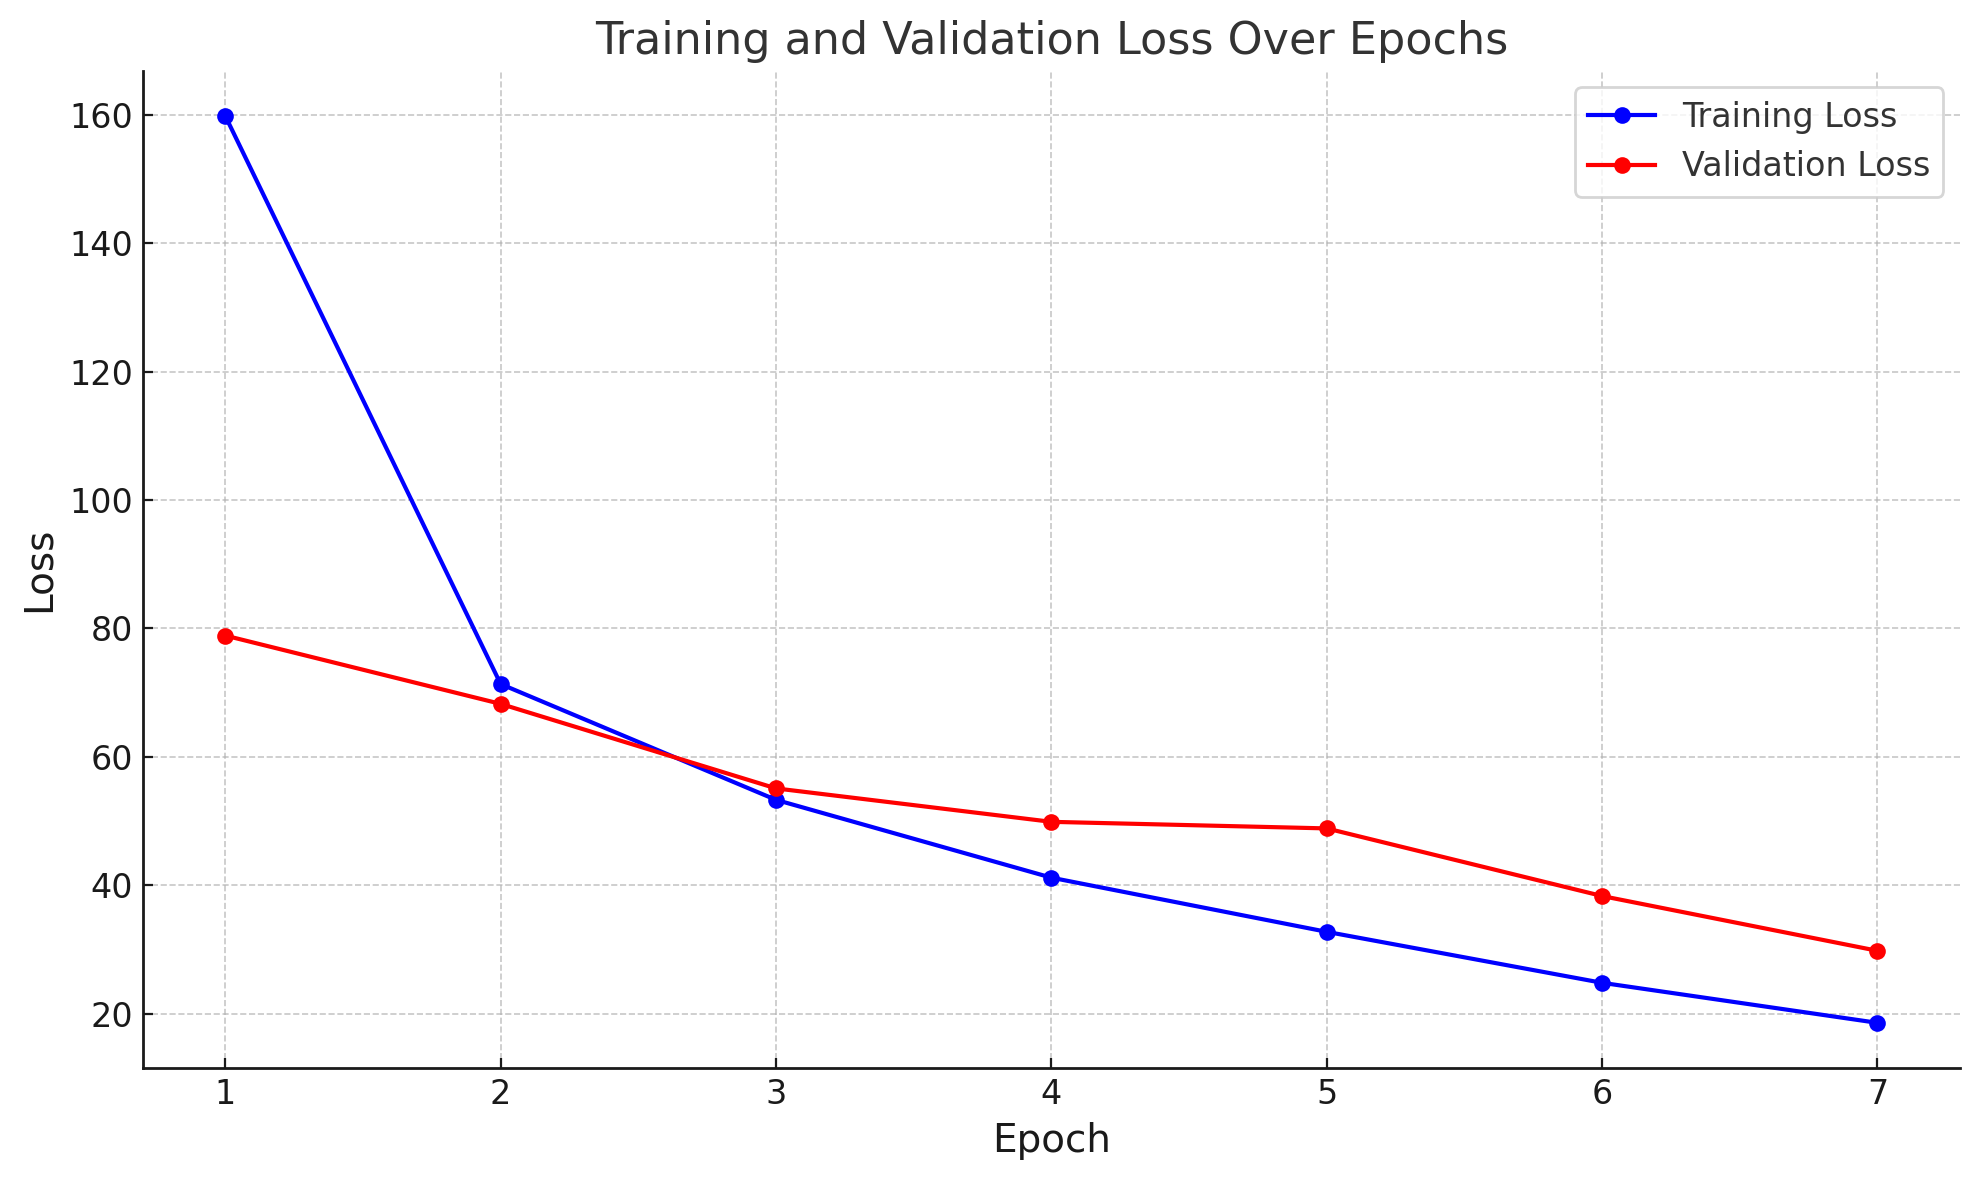